<a href="https://colab.research.google.com/github/ddraedd/Decoding-Motor-Intention-from-Neural-Signals-Using-a-Simple-Neural-Network/blob/main/MT_S1_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [38]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import scipy.io

mat_file_path = "/content/drive/MyDrive/primate spike data/data_and_scripts/source_data/raw/MT_S1_raw.mat"
MT_S1 = scipy.io.loadmat(mat_file_path)

MT_S1.keys()


dict_keys(['__header__', '__version__', '__globals__', 'PMd', 'cont', 'trial_table'])

In [6]:
pmd = MT_S1['PMd'][0, 0]
cont = MT_S1['cont'][0, 0]
t = cont['t'].flatten()
position = cont['pos']
pmd_units = MT_S1['PMd'][0, 0]['units']
pmd_trialTable = MT_S1['trial_table']

In [7]:
# visulaizing units in a single trial
pmd_units[0][0]

np.void((array([[93,  1]], dtype=uint8), array([[  3.5 ,   3.5 ,   4.5 , ...,   7.5 ,  -7.5 ,  -7.25],
       [  1.75,  -2.5 ,   7.75, ...,   5.  , -12.25,  -5.5 ],
       [  0.  ,  -4.25,   5.75, ...,   9.  , -17.  ,  -6.25],
       ...,
       [ -3.75,  11.5 ,  -4.5 , ..., -17.  ,   6.25,  12.75],
       [  2.5 ,  10.  ,   0.75, ..., -10.75,   5.5 ,   6.25],
       [  6.5 ,  -3.  ,  -3.  , ...,  -8.5 ,   8.25,   2.5 ]]), array([[2.89000000e-02],
       [5.01000000e-02],
       [1.07800000e-01],
       ...,
       [8.04638733e+02],
       [8.04648133e+02],
       [8.04741400e+02]]), array([[2586]], dtype=uint16), array([[63.65854602]]), array([[0.21418738]]), array([[3.21345466]]), array([[1]], dtype=uint8)), dtype=[('id', 'O'), ('wf', 'O'), ('ts', 'O'), ('ns', 'O'), ('p2p', 'O'), ('misi', 'O'), ('mfr', 'O'), ('offline_sorter_channel', 'O')])

In [8]:
def extract_spike_counts_matrix(units, trial_table, window_s=0.5, event_col=2, label_col=7):
    """
    Extracts spike count matrix (n_trials x n_units) from neural data.

    Parameters:
    - units: array of unit structs (from m1['units'])
    - trial_table: array containing trial start/go cue/end etc.
    - window_s: window (in seconds) before go cue to count spikes
    - event_col: index of event to align to (e.g., go cue = 2)
    - label_col: index of label to predict (e.g., reach direction = 7)

    Returns:
    - X: np.array of shape (n_trials, n_units), spike counts
    - y: np.array of shape (n_trials,), labels
    """
    n_trials = trial_table.shape[0]
    n_units = units.shape[0]
    X = np.zeros((n_trials, n_units))
    y = []

    for i in range(n_trials):
        trial = trial_table[i]
        align_time = trial[event_col]  # go cue or other time
        label = trial[label_col]
        y.append(label)

        for j in range(n_units):
            spike_times = units[j][0]['ts'].flatten()
            count = ((spike_times > (align_time - window_s)) & (spike_times <= align_time)).sum()
            X[i, j] = count

    return X, np.array(y)


In [9]:
spike_cnt_mat, y = extract_spike_counts_matrix(pmd_units, pmd_trialTable)

In [32]:
# Normalizing the spike data (mean=0, unit var)
scaler = StandardScaler()
spike_cnt_scaled = scaler.fit_transform(spike_cnt_mat)

In [33]:
# Extract trial result column (index 22 in 0-based Python)
trial_result = pmd_trialTable[:, 22]

# Only keep successful (82) and failed (70)
valid_mask = np.isin(trial_result, [82, 70])
X_final = spike_cnt_scaled[valid_mask]
y_final = (trial_result[valid_mask] == 82).astype(int)  # 1 = success, 0 = failure



In [35]:
# train and test data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)


In [36]:
# train a feedforward neural network

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [37]:
# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Model, loss, optimizer
model = SimpleNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6926
Epoch 5, Loss: 0.6410
Epoch 10, Loss: 0.5929
Epoch 15, Loss: 0.5484
Epoch 20, Loss: 0.5073
Epoch 25, Loss: 0.4695
Epoch 30, Loss: 0.4350
Epoch 35, Loss: 0.4033
Epoch 40, Loss: 0.3744
Epoch 45, Loss: 0.3479


In [39]:
model.eval()
with torch.no_grad():
    pred_probs = model(X_test_t).numpy().squeeze()
    preds = (pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, pred_probs)

print(f"Test Accuracy: {acc:.3f}, AUC: {auc:.3f}")

Test Accuracy: 1.000, AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Prediction Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


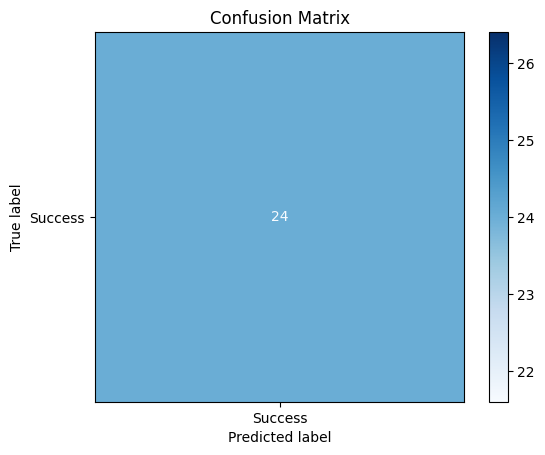

In [42]:
# Create confusion matrix
cm = confusion_matrix(y_test, preds)
unique_labels = np.unique(y_test)

# Dynamically choose display labels
label_names = {0: "Fail", 1: "Success"}
display_labels = [label_names[i] for i in unique_labels]

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


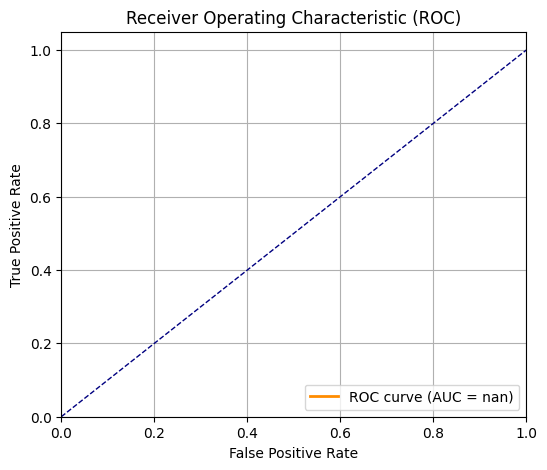

In [41]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
